In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [27]:
day_10_returns = pd.read_csv('10_days_returns.csv', index_col = 'Date')
daily_log_returns = pd.read_csv('log_returns.csv', index_col = 'Date')

# 1. Данные

In [3]:
day_10_returns.head()

,HSBA.UK,BARC.UK,LLOY.UK,RBS.UK,BP.UK,RDSA.UK,RIO.UK,AAL.UK
Date,,,,,,,,
2009-01-20,-0.245792,-0.570689,-0.638392,-0.789787,-0.049165,-0.039889,-0.185980,-0.242904
2009-01-21,-0.194892,-0.626511,-0.648756,-0.752959,-0.086976,-0.089082,-0.127155,-0.189779
2009-01-22,-0.161517,-0.669258,-0.626603,-0.770249,-0.056389,-0.062640,-0.057660,-0.148328
2009-01-23,-0.192959,-0.722670,-0.649604,-0.779998,-0.042250,-0.033841,-0.052290,-0.124745
2009-01-26,-0.154677,-0.465324,-0.509773,-0.716253,-0.014559,-0.006659,0.064955,-0.046174


In [28]:
daily_log_returns.head()

,HSBA.UK,BARC.UK,LLOY.UK,RBS.UK,BP.UK,RDSA.UK,RIO.UK,AAL.UK
Date,,,,,,,,
2009-01-08,-0.004263,0.041391,0.035700,0.032131,0.015623,0.019748,-0.046308,-0.060947
2009-01-09,-0.018528,0.011321,0.023823,0.048230,-0.024721,-0.029211,-0.059539,-0.085504
2009-01-12,0.016131,0.030917,0.067646,0.035145,-0.019452,-0.008425,-0.014191,-0.026527
2009-01-13,0.001951,-0.106936,-0.056291,-0.073541,0.012655,0.016224,-0.032909,-0.015284
2009-01-14,-0.083424,-0.154790,-0.126437,-0.203287,-0.053282,-0.052404,-0.119406,-0.100002


# 2. Описание данных

Выведим описательные статистики, skew, kurtosis и автокорреляцию по первому лагу.

In [5]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [8]:
description = day_10_returns.describe()

colnames = list(day_10_returns.columns)
autocorrelation = []

for colname in colnames:
    autocorrelation.append(day_10_returns[colname].autocorr(lag = 1))
    
autocorr = pd.DataFrame([autocorrelation], columns = colnames, index=['autocorr'])
skews = pd.DataFrame([skew(day_10_returns, axis = 0).tolist()], columns = colnames, index=['skew'])
kurt = pd.DataFrame([kurtosis(day_10_returns, axis = 0).tolist()], columns = colnames, index=['kurtosis'])

description = description.append(autocorr)
description = description.append(skews)
description = description.append(kurt)

In [10]:
description

,HSBA.UK,BARC.UK,LLOY.UK,RBS.UK,BP.UK,RDSA.UK,RIO.UK,AAL.UK
count,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000
mean,0.001548,0.013534,-0.000657,0.004652,0.001007,0.004643,0.014518,0.009401
std,0.064685,0.150058,0.153627,0.147392,0.063216,0.046326,0.084188,0.079307
min,-0.290343,-0.722670,-0.649604,-0.789787,-0.298137,-0.195308,-0.233768,-0.316247
25%,-0.030701,-0.051445,-0.067942,-0.064734,-0.028745,-0.024213,-0.037974,-0.040067
50%,-0.002056,-0.003666,-0.010334,-0.007179,0.005585,0.007588,0.013533,0.009936
75%,0.030232,0.059088,0.051077,0.062105,0.036411,0.034025,0.066666,0.058990
max,0.298901,0.953121,1.040486,0.980523,0.314099,0.195335,0.317943,0.334882
autocorr,0.868376,0.899319,0.886610,0.864620,0.914782,0.887964,0.875743,0.861956
skew,0.227118,1.614231,1.135613,0.506285,-0.130752,-0.489483,0.150237,-0.149318


# 3. VaR и ES для акций

## Дельта-нормальный метод

Зададим вектор весов.

In [15]:
weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])

Найдем ковариационную матрицу.

In [34]:
cov = np.array(daily_log_returns.cov())
pd.DataFrame(cov)

,0,1,2,3,4,5,6,7
0,0.000553,0.000645,0.000716,0.000661,0.000158,0.000175,0.000388,0.000397
1,0.000645,0.002255,0.001655,0.001554,0.000295,0.000275,0.000701,0.000686
2,0.000716,0.001655,0.002834,0.002231,0.000237,0.000255,0.000635,0.000684
3,0.000661,0.001554,0.002231,0.003474,0.000243,0.000222,0.000642,0.000686
4,0.000158,0.000295,0.000237,0.000243,0.000374,0.000174,0.000248,0.000242
5,0.000175,0.000275,0.000255,0.000222,0.000174,0.000235,0.000275,0.000267
6,0.000388,0.000701,0.000635,0.000642,0.000248,0.000275,0.000928,0.000724
7,0.000397,0.000686,0.000684,0.000686,0.000242,0.000267,0.000724,0.000872


Найдем дисперсию портфеля.

In [63]:
var_log_p = weights@cov@weights
np.sqrt(var_log_p)

0.02347867646291536

### Найдем VaR

In [64]:
import scipy.stats as st

In [65]:
VaR_10 = np.sqrt(var_log_p) * st.norm.ppf(.99) * np.sqrt(10)
VaR_10

0.17272224309325065

### Найдем ES

In [67]:
ES = np.sqrt(var_log_p) * st.norm.pdf(st.norm.ppf(.01))/0.01 * np.sqrt(10)
ES

0.19788174571782707

## Исторический метод

Найдем доходности портфеля.

In [129]:
return_10_p = day_10_returns@weights

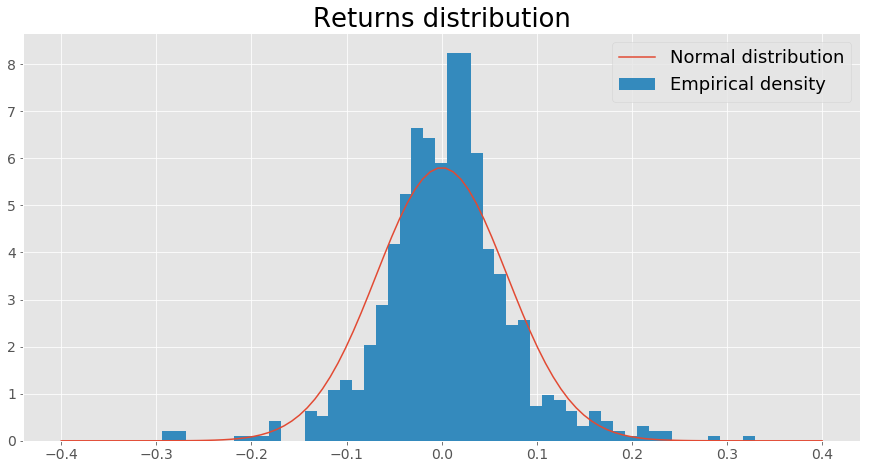

In [145]:
plt.figure(figsize=(15,7.5))
plt.tick_params(labelsize=14)
plt.title('Returns distribution')
sigma = return_10_p.std()

x = np.linspace(-0.4, 0.4, 100)
plt.plot(x, st.norm(loc = 0, scale = sigma).pdf(x))


plt.hist(var_10_p,bins=50, density = True)
plt.legend(['Normal distribution', 'Empirical density']);

Найдем VaR.

In [131]:
var_location = int(np.floor(return_10_p.shape[0] * 0.01))
sorted_var_10_p = return_10_p.sort_values()

In [132]:
sorted_var_10_p[var_location]

-0.1761003463960912

Найдем ES.

In [133]:
sorted_var_10_p[:var_location].mean()

-0.24651355981852946

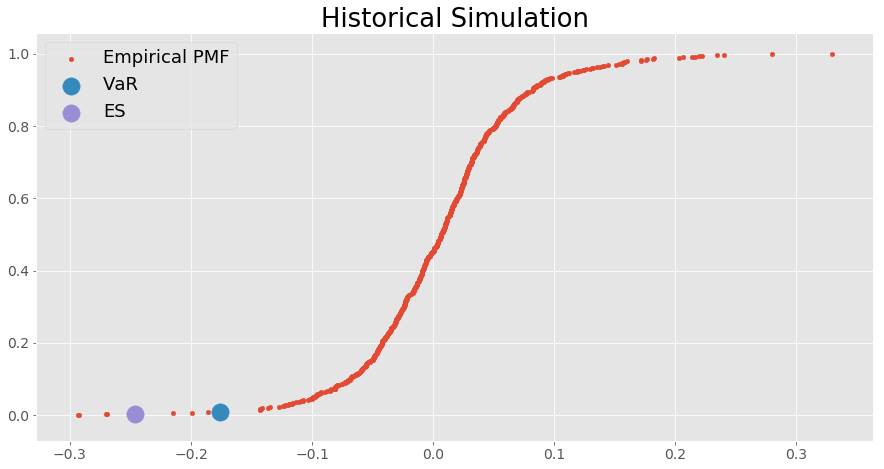

In [147]:
plt.figure(figsize=(15,7.5))
plt.tick_params(labelsize=14)
plt.scatter(sorted_var_10_p, np.linspace(0, 1, return_10_p.shape[0]), s = 20)
plt.scatter(sorted_var_10_p[var_location], np.linspace(0, 1, return_10_p.shape[0])[var_location], s = 300)
plt.scatter(sorted_var_10_p[:var_location].mean(), np.linspace(0, 1, return_10_p.shape[0])[:var_location].mean(), s = 300)
plt.title('Historical Simulation')
plt.legend(['Empirical PMF', 'VaR', 'ES']);